In [1]:
import torch
from torch import nn

In [2]:
from sys import path ; path.append("..")
from torchdyn.numerics import *
from torchdyn.numerics.odeint import *
from torchdyn.numerics.systems import VanDerPol

In [3]:
z = torch.randn(100, 2)
t_span = torch.linspace(0, 1, 100)
net = nn.Sequential(
        nn.Linear(2, 2),
        nn.ReLU(),
        nn.Linear(2, 2),
        nn.Tanh(),
        nn.Linear(2, 2)
)
def f(t, z):
    return net(z)


In [5]:
t, zT = odeint(VanDerPol(), z, t_span, solver='rk4')
t, zTm = odeint_mshooting(VanDerPol(), z, t_span, solver='newton', 
                          B0=zT, fine_steps=2, maxiter=1)

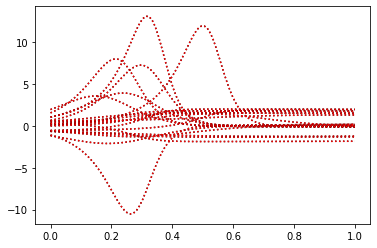

In [6]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(t_span, zT[:,i,:].detach(), ':k')
    plt.plot(t_span, zTm[:,i,:].detach(), ':r')

In [6]:
device = torch.device("cuda:1")

z = torch.randn(1000, 2).to(device)
t_span = torch.linspace(0, 5, 500).to(device)
_, z_init = odeint(VanDerPol(), z, t_span, solver='dopri5', atol=1e-7, rtol=1e-7, interpolator='4th')

In [7]:
%timeit odeint_mshooting(VanDerPol(), z, t_span[::2], solver='newton', B0=z_init[::2], fine_steps=4, maxiter=1)

57.9 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%timeit odeint(VanDerPol(), z, t_span, solver='rk4')

257 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit odeint(VanDerPol(), z, t_span, solver='dopri5', atol=1e-5, rtol=1e-5, interpolator='4th')

929 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from torch import nn, eye
class ForwardSensitivity(nn.Module):
    "Forward sensitivity for ODEs. Integrates the ODE returning the state and forward sensitivity"
    def __init__(self, f):
        super().__init__()
        self.f = f

    def forward(self, z0, t_span, odeint_func=odeint, solver='rk4', atol=1e-5, rtol=1e-5):
        I = eye(z0.shape[-1]).to(z0)
        # handle regular `batch, dim` case as well as `seq_dim, batch, dim`
        v0 = I.repeat(z0.shape[0], 1, 1) if len(z0.shape) < 3 else I.repeat(*z0.shape[:2], 1, 1)
        
        self.z_shape, self.v_shape = z0.shape, v0.shape        

        zv0 = self._ravel_state(z0, v0)
        _, zvT = odeint_func(self._sensitivity_dynamics, zv0, t_span, 
                        solver=solver)#, atol=atol, rtol=rtol, interpolator='4th')
        zT, vT = self._unravel_state(zvT)
        return zT, vT

    def _sensitivity_dynamics(self, t, zv):
        z, v = self._unravel_state(zv)
        # compute vector field
        dz = self.f(t, z.requires_grad_(True))
        # compute fw sensitivity via mjp
        dv = self._mjp(dz, z, v)
        return self._ravel_state(dz, dv)
    
    def _mjp(self, f, z, v):
        """Parallel computation of matrix jacobian products with vmap
        """
        def get_vjp(v):
            return torch.autograd.grad(f, z, v, retain_graph=True)[0]
        return vmap(get_vjp, in_dims=2, out_dims=2)(v)
    
    def _ravel_state(self, z, v):  
        v = v.reshape(*z.shape[:-1], -1)
        zv = torch.cat([z, v], -1)
        return zv
    
    def _unravel_state(self, zv):
        z, v = zv[...,:self.z_shape[-1]], zv[...,self.z_shape[-1]:]
        v = v.reshape(*z.shape, self.z_shape[-1])
        return z, v

In [ ]:
z = torch.randn(100, 2)
t_span = torch.linspace(0, 1, 10)
net = nn.Sequential(
        nn.Linear(2, 2),
        nn.Tanh(),
        nn.Linear(2, 2),
        nn.Tanh(),
        nn.Linear(2, 2)
)
def f(t, z):
    return net(z)
fsens = ForwardSensitivity(f)

In [46]:
zT, vT = fsens(z, t_span)

In [47]:
zT.shape

torch.Size([10, 100, 2])

In [56]:
from torchdyn.numerics.solvers import AsynchronousLeapfrog, Tsitouras45, str_to_solver, str_to_ms_solver

class MShootingSolverTemplate(nn.Module):
    def __init__(self, coarse_method, fine_method):
        super().__init__()
        if type(coarse_method) == str: self.coarse_method = str_to_solver(coarse_method)
        if type(fine_method) == str: self.fine_method = str_to_solver(fine_method)

    def sync_device_dtype(self, x, t_span):
        "Ensures `x`, `t_span`, `tableau` and other solver tensors are on the same device with compatible dtypes"
        x, t_span = self.coarse_method.sync_device_dtype(x, t_span)
        x, t_span = self.fine_method.sync_device_dtype(x, t_span)  
        return x, t_span

    def root_solve(self, odeint_func, f, x, t_span, B, fine_steps, maxiter):
        pass
    
class MSForward(MShootingSolverTemplate):
    """Multiple shooting solver using forward sensitivity analysis on the matching conditions of shooting parameters"""
    def __init__(self, coarse_method='euler', fine_method='rk4'):
        super().__init__(coarse_method, fine_method)
        self.fsens = None

    def root_solve(self, odeint_func, f, x, t_span, B, fine_steps, maxiter):
        if self.fsens is None:
            self.fsens = ForwardSensitivity(f)
            
        dt, n_subinterv = t_span[1] - t_span[0], len(t_span)
        sub_t_span = torch.linspace(0, dt, fine_steps).to(x)
        i = 0
        while i <= maxiter:
            i += 1
            with torch.set_grad_enabled(True):
                B_fine, V_fine = self.fsens(B[i - 1:], sub_t_span, odeint_func=odeint_func, 
                                            solver=self.fine_method)
            B_fine, V_fine = B_fine[-1], V_fine[-1]
            B_out = torch.zeros_like(B)
            B_out[:i] = B[:i]
            B_in = B[i - 1]
            for m in range(i, n_subinterv):
                B_in = B_fine[m - i] + torch.einsum('bij, bj -> bi', V_fine[m - i], B_in - B[m - 1])
                B_out[m] = B_in
            B = B_out
        return B

In [61]:
from torchdyn.numerics.odeint import odeint_mshooting

t, zT = odeint(f, z, t_span, solver='rk4')
t, zTm = odeint_mshooting(f, z, t_span, solver=MSForward())

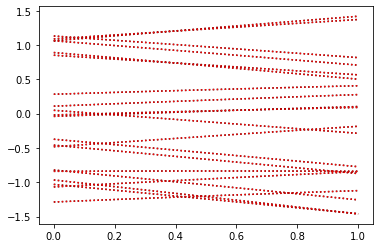

In [62]:
import matplotlib.pyplot as plt
for i in range(10):
    plt.plot(t_span, zT[:,i,:].detach(), ':k')
    plt.plot(t_span, zTm[:,i,:].detach(), ':r')

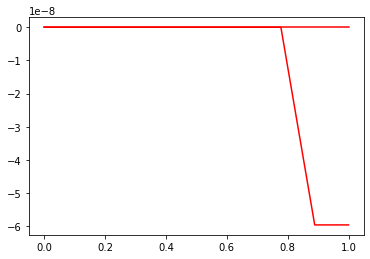

In [64]:
plt.plot(t_span, zTm[:,i,:].detach()-zT[:,i,:].detach(), 'r')